In [1]:
!pip install bt
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install talib-binary
!pip install statsmodels==0.12.1

     |████████████████████████████████| 2.7 MB 27.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bt: filename=bt-0.2.9-cp37-cp37m-linux_x86_64.whl size=765315 sha256=1fb54186328e43f8d65cd2d48beced7fdcc7586f69d205792a626834aed4b9ae
  Stored in directory: /root/.cache/pip/wheels/c5/1a/3f/b56e6064b766c107f25e200969161c09ca6868cbfe0eaa31e4
Successfully built bt
     |████████████████████████████████| 109 kB 26.7 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
     |████████████████████████████████| 2.4 MB 28.6 MB/s 
     |████████████████████████████████| 9.5 MB 25.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmo

In [2]:
import bt
import talib
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
from datetime import timedelta
import time
import os
from urllib.parse import urlencode
from urllib.request import urlopen
import urllib.request
# import data reader package
import pandas_datareader as pdr
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 5)
import warnings
warnings.filterwarnings("ignore")

import itertools
import holidays
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE

# Stats packages
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


In [3]:
#на вход должна быть подана база с барами
def edit_FinamFile (load_df):
    data_finam = load_df
        
    #преобразуем дату в формат datetime и переименуем колонки
    data_finam = data_finam[['<PER>', '<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']]
    data_finam.rename(columns={'<PER>':'PER','<DATE>':'Date','<TIME>':'Time', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Volume'}, inplace=True)
    data_finam["Date"]=pd.to_datetime(data_finam["Date"], format = "%Y%m%d")
    data_finam['DateTime'] = pd.to_datetime((data_finam["Date"].astype(str)+' '+data_finam["Time"].astype(str).str.zfill(6)), format = "%Y%m%d %H:%M:%S")

    # Подключаем доступ к "datetime accessor". Это можно сделать через dt=Series.dt., необходимо для того чтобы можно было извлечь dt.hour, dt.minute, dt.second
    # (hour=Series.dt.hour, minute=Series.dt.minute, second=Series.dt.second)
    # добавим колонки "Hour", "Minute"
    # Первый способ (тип datetime)
    data_finam['Hour'] = data_finam['DateTime'].dt.hour
    data_finam['Minute'] = data_finam['DateTime'].dt.minute 
    # Второй способ (тип float)
    # data_finam['Time']=data_finam['Time'].replace(0,100000)
    # data_finam["Hour"]=np.trunc(data_finam["Time"]/10000)
    # data_finam["Minute"]=np.trunc((data_finam["Time"]-data_finam["Hour"]*10000)/100)
    # Третий способ (тип str)
    # data_finam['Time']=data_finam['Time'].astype(str).str.zfill(6)
    # data_finam["Hour"]=(data_finam["Time"].astype(int)/10000).astype(int).astype(str).str.zfill(2)
    # data_finam["Minute"]=((data_finam["Time"].astype(int)-(data_finam["Hour"].astype(int))*10000)/100).astype(int).astype(str).str.zfill(2) 

    #перстановка колонок местами
    data_finam=data_finam.reindex(columns=['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'PER', 'Date', 'Time', 'Hour', 'Minute']).set_index(['DateTime'])
    print(data_finam.head(10))
    data_finam
  
    return data_finam

In [4]:
def finam_export (ticker, period, start, end):
    #пользовательские переменные
    ticker = ticker #задаём тикер
    period=period # задаём период. Выбор из: 'tick': 1, 'min': 2, '5min': 3, '10min': 4, '15min': 5, '30min': 6, 'hour': 7, 'daily': 8, 'week': 9, 'month': 10
    start = start #с какой даты начинать тянуть котировки
    end = end #финальная дата, по которую тянуть котировки
    ########
    periods={'tick': 1, 'min': 2, '5min': 3, '10min': 4, '15min': 5, '30min': 6, 'hour': 7, 'daily': 8, 'week': 9, 'month': 10}
    print ("ticker="+ticker+"; period="+str(period)+"; start="+start+"; end="+end)
    #каждой акции Финам присвоили цифровой код(token), именно по его коду стучимся в Финам. 
    #Его можно увидеть в поисковой строке когда переходишь на страницу Финам для экспорта данных по активу
    tickers={'comex.GC':18953,'ICE.BRN':19473, 'NYMEX.CL':18948, 'NYMEX.NG':18949,'USDRUB':901,'EURRUB':66860,'INDUSDX':438796,'EURUSD':83,'ABRD':82460,'AESL':181867,'AFKS':19715,'AFLT':29,'AGRO':399716,'AKRN':17564,'ALBK':82616,'ALNU':81882,'ALRS':81820,'AMEZ':20702,'APTK':13855,'AQUA':35238,'ARMD':19676,'ARSA':19915,'ASSB':16452,'AVAN':82843,'AVAZ':39,'AVAZP':40,'BANE':81757,'BANEP':81758,'BGDE':175840,'BISV':35242,'BISVP':35243,'BLNG':21078,'BRZL':81901,'BSPB':20066,'CBOM':420694,'CHEP':20999,'CHGZ':81933,'CHKZ':21000,'CHMF':16136,'CHMK':21001,'CHZN':19960,'CLSB':16712,'CLSBP':16713,'CNTL':21002,'CNTLP':81575,'DASB':16825,'DGBZ':17919,'DIOD':35363,'DIXY':18564,'DVEC':19724,'DZRD':74744,'DZRDP':74745,'ELTZ':81934,'ENRU':16440,'EPLN':451471,'ERCO':81935,'FEES':20509,'FESH':20708,'FORTP':82164,'GAZA':81997,'GAZAP':81998,'GAZC':81398,'GAZP':16842,'GAZS':81399,'GAZT':82115,'GCHE':20125,'GMKN':795,'GRAZ':16610,'GRNT':449114,'GTLC':152876,'GTPR':175842,'GTSS':436120,'HALS':17698,'HIMC':81939,'HIMCP':81940,'HYDR':20266,'IDJT':388276,'IDVP':409486,'IGST':81885,'IGST03':81886,'IGSTP':81887,'IRAO':20516,'IRGZ':9,'IRKT':15547,'ISKJ':17137,'JNOS':15722,'JNOSP':15723,'KAZT':81941,'KAZTP':81942,'KBSB':19916,'KBTK':35285,'KCHE':20030,'KCHEP':20498,'KGKC':83261,'KGKCP':152350,'KLSB':16329,'KMAZ':15544,'KMEZ':22525,'KMTZ':81903,'KOGK':20710,'KRKN':81891,'KRKNP':81892,'KRKO':81905,'KRKOP':81906,'KROT':510,'KROTP':511,'KRSB':20912,'KRSBP':20913,'KRSG':15518,'KSGR':75094,'KTSB':16284,'KTSBP':16285,'KUBE':522,'KUNF':81943,'KUZB':83165,'KZMS':17359,'KZOS':81856,'KZOSP':81857,'LIFE':74584,'LKOH':8,'LNTA':385792,'LNZL':21004,'LNZLP':22094,'LPSB':16276,'LSNG':31,'LSNGP':542,'LSRG':19736,'LVHK':152517,'MAGE':74562,'MAGEP':74563,'MAGN':16782,'MERF':20947,'MFGS':30,'MFGSP':51,'MFON':152516,'MGNT':17086,'MGNZ':20892,'MGTS':12984,'MGTSP':12983,'MGVM':81829,'MISB':16330,'MISBP':16331,'MNFD':80390,'MOBB':82890,'MOEX':152798,'MORI':81944,'MOTZ':21116,'MRKC':20235,'MRKK':20412,'MRKP':20107,'MRKS':20346,'MRKU':20402,'MRKV':20286,'MRKY':20681,'MRKZ':20309,'MRSB':16359,'MSNG':6,'MSRS':16917,'MSST':152676,'MSTT':74549,'MTLR':21018,'MTLRP':80745,'MTSS':15523,'MUGS':81945,'MUGSP':81946,'MVID':19737,'NAUK':81992,'NFAZ':81287,'NKHP':450432,'NKNC':20100,'NKNCP':20101,'NKSH':81947,'NLMK':17046,'NMTP':19629,'NNSB':16615,'NNSBP':16616,'NPOF':81858,'NSVZ':81929,'NVTK':17370,'ODVA':20737,'OFCB':80728,'OGKB':18684,'OMSH':22891,'OMZZP':15844,'OPIN':20711,'OSMP':21006,'OTCP':407627,'PAZA':81896,'PHOR':81114,'PHST':19717,'PIKK':18654,'PLSM':81241,'PLZL':17123,'PMSB':16908,'PMSBP':16909,'POLY':175924,'PRFN':83121,'PRIM':17850,'PRIN':22806,'PRMB':80818,'PRTK':35247,'PSBR':152320,'QIWI':181610,'RASP':17713,'RBCM':74779,'RDRB':181755,'RGSS':181934,'RKKE':20321,'RLMN':152677,'RLMNP':388313,'RNAV':66644,'RODNP':66693,'ROLO':181316,'ROSB':16866,'ROSN':17273,'ROST':20637,'RSTI':20971,'RSTIP':20972,'RTGZ':152397,'RTKM':7,'RTKMP':15,'RTSB':16783,'RTSBP':16784,'RUAL':414279,'RUALR':74718,'RUGR':66893,'RUSI':81786,'RUSP':20712,'RZSB':16455,'SAGO':445,'SAGOP':70,'SARE':11,'SAREP':24,'SBER':3,'SBERP':23,'SELG':81360,'SELGP':82610,'SELL':21166,'SIBG':436091,'SIBN':2,'SKYC':83122,'SNGS':4,'SNGSP':13,'STSB':20087,'STSBP':20088,'SVAV':16080,'SYNG':19651,'SZPR':22401,'TAER':80593,'TANL':81914,'TANLP':81915,'TASB':16265,'TASBP':16266,'TATN':825,'TATNP':826,'TGKA':18382,'TGKB':17597,'TGKBP':18189,'TGKD':18310,'TGKDP':18391,'TGKN':18176,'TGKO':81899,'TNSE':420644,'TORS':16797,'TORSP':16798,'TRCN':74561,'TRMK':18441,'TRNFP':1012,'TTLK':18371,'TUCH':74746,'TUZA':20716,'UCSS':175781,'UKUZ':20717,'UNAC':22843,'UNKL':82493,'UPRO':18584,'URFD':75124,'URKA':19623,'URKZ':82611,'USBN':81953,'UTAR':15522,'UTII':81040,'UTSY':419504,'UWGN':414560,'VDSB':16352,'VGSB':16456,'VGSBP':16457,'VJGZ':81954,'VJGZP':81955,'VLHZ':17257,'VRAO':20958,'VRAOP':20959,'VRSB':16546,'VRSBP':16547,'VSMO':15965,'VSYD':83251,'VSYDP':83252,'VTBR':19043,'VTGK':19632,'VTRS':82886,'VZRZ':17068,'VZRZP':17067,'WTCM':19095,'WTCMP':19096,'YAKG':81917,'YKEN':81766,
             'BTSX.BTCUSD':499054, 'BTSX.ETHUSD':499048, 'US1.AAPL':20569, 'US1.AMZN':874205,'US1.FB':874399,'US1.MSFT':19068, 'US1.GOOG':20590, 'US2.BIDU':20574,'YKENP':81769,'YNDX':388383,'YRSB':16342,'YRSBP':16343,'ZHIV':181674,'ZILL':81918,'ZMZN':556,'ZMZNP':603,'ZVEZ':82001}
    FINAM_URL = "https://export.finam.ru/"# сервер, на который стучимся
    market = 5 #можно не задавать. Это рынок, на котором торгуется бумага. Для акций работает с любой цифрой. Другие рынки не проверяли.
    #Делаем преобраз:ования дат:
    start_date = datetime.strptime(start, "%Y-%m-%d").date()
    start_date_rev=datetime.strptime(start, "%Y-%m-%d").strftime('%Y-%m-%d')
    end_date = datetime.strptime(end, "%Y-%m-%d").date()
    end_date_rev=datetime.strptime(end, "%Y-%m-%d").strftime('%Y-%m-%d')
    #Все параметры упаковываем в единую структуру. Здесь есть дополнительные параметры, кроме тех, которые заданы в шапке. См. комментарии внизу:
    params = urlencode([
                        ('market', market), #на каком рынке торгуется бумага
                        ('em', tickers[ticker]), #вытягиваем цифровой символ, который соответствует бумаге.
                        ('code', ticker), #тикер нашей акции
                        ('apply',0), #не нашёл что это значит. 
                        ('df', start_date.day), #Начальная дата, номер дня (1-31)
                        ('mf', start_date.month - 1), #Начальная дата, номер месяца (0-11)
                        ('yf', start_date.year), #Начальная дата, год
                        ('from', start_date), #Начальная дата полностью
                        ('dt', end_date.day), #Конечная дата, номер дня	
                        ('mt', end_date.month - 1), #Конечная дата, номер месяца
                        ('yt', end_date.year), #Конечная дата, год
                        ('to', end_date), #Конечная дата
                        ('p', period), #Таймфрейм
                        ('f', ticker+"_" + start_date_rev + "_" + end_date_rev+"_"+str(period)), #Имя сформированного файла
                        ('e', ".csv"), #Расширение сформированного файла
                        ('cn', ticker), #ещё раз тикер акции	
                        ('dtf', 1), #В каком формате брать даты. Выбор из 5 возможных. См. страницу https://www.finam.ru/profile/moex-akcii/sberbank/export/
                        ('tmf', 1), #В каком формате брать время. Выбор из 4 возможных.
                        ('MSOR', 1), #Время свечи (0 - open; 1 - close)	
                        ('mstime', "on"), #Московское время	
                        ('mstimever', 1), #Коррекция часового пояса	
                        ('sep', 3), #Разделитель полей	(1 - запятая, 2 - точка, 3 - точка с запятой, 4 - табуляция, 5 - пробел)
                        ('sep2', 1), #Разделитель разрядов
                        ('datf', 1), #Формат записи в файл. Выбор из 6 возможных.
                        ('at', 1)]) #Нужны ли заголовки столбцов
    
    #Создаем url-запрос, по которому будем получать бары из Финам
    url = FINAM_URL + ticker+"_" + start_date_rev + "_" + end_date_rev + ".csv?" + params #урл составлен! Именно по этому запросу получаем истор.данные цен
    print("Стучимся на Финам по ссылке: "+url)
 
    #Заранее узнали user_agent своего собственного компьютера и браузеров, чтобы достучатья до Финам по url-запросу
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36" #Его каждый раз надо узнавать для разных компов. МОжно узнать по адресу https://xn--80agecg4bru4h.xn--p1ai/
    headers={'User-Agent':user_agent,} 

    #Отправляем запросы на Финам и считываем ответы
    request=urllib.request.Request(url,None,headers) #The assembled request
    response = urllib.request.urlopen(request).readlines() #здесь лежит огромный массив данных, прилетевший с Финама.

    #Создаем файлы и записываем ответы Финам построчно, для того чтобы потом считать данные из файла
    local_file = open('stock_price_finam.csv', "w") #задаём файл, в который запишем котировки.
    for line in response: #записываем свечи строку за строкой. 
      local_file.write(line.strip().decode( "utf-8" )+'\n')	
    local_file.close()
    print("Готово. Проверьте файл stock_price_finam.csv в папке где лежит скрипт")

    #Считываем данные из файла и создаем pd.DataFrame
    load_finam = pd.read_csv('stock_price_finam.csv', delimiter=';')

    # #Дальше код для преобразовывания pd.DataFrame под нужную структуру данных
  
    #преобразуем дату в формат datetime и переименуем колонки
    data_finam = load_finam[['<PER>', '<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']]
    data_finam.rename(columns={'<PER>':'PER','<DATE>':'Date','<TIME>':'Time', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Volume'}, inplace=True)
    data_finam["Date"]=pd.to_datetime(data_finam["Date"], format = "%Y%m%d")
    data_finam['DateTime'] = pd.to_datetime((data_finam["Date"].astype(str)+' '+data_finam["Time"].astype(str).str.zfill(6)), format = "%Y%m%d %H:%M:%S")

    # Подключаем доступ к "datetime accessor". Это можно сделать через dt=Series.dt., необходимо для того чтобы можно было извлечь dt.hour, dt.minute, dt.second 
    # (hour=Series.dt.hour, minute=Series.dt.minute, second=Series.dt.second)
    # добавим колонки "Hour", "Minute"
    data_finam['Hour'] = data_finam['DateTime'].dt.hour
    data_finam['Minute'] = data_finam['DateTime'].dt.minute 

    #перестановка колонок местами
    data_finam=data_finam.reindex(columns=['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'PER', 'Date', 'Time', 'Hour', 'Minute']).set_index(['DateTime'])
    # print(data_finam.head(10))
    data_finam

    
    return data_finam

In [5]:
def long_only_ew(ticker, data_load, short_ma=12, long_ma=26, learn_price='Close', timeperiod=14, view=True, name='long_only_ew'):
    # these are all the same steps as above
    price_data = data_load
    data = price_data[learn_price]
    data.columns = [ticker]

    # these are all indicators
    stock_rsi = talib.RSI(data, timeperiod=timeperiod)
    stock_adx = talib.ADX(price_data['High'], price_data['Low'], price_data['Close'], timeperiod=timeperiod)
    upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data, nbdevup=2.5, nbdevdn=2.5, timeperiod=timeperiod)
    upper_05sd, mid_05sd, lower_05sd = talib.BBANDS(data, nbdevup=0.5, nbdevdn=0.5, timeperiod=timeperiod)
    short_ema = talib.EMA(data, timeperiod=short_ma)
    long_ema = talib.EMA(data, timeperiod=long_ma)

    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()], [ticker])
    
    if view==True:
      tmp = bt.merge(data, upper_2sd, mid_2sd, lower_2sd, short_ema, long_ema, upper_05sd, lower_05sd)
      tmp.columns = ['price', 'upper_2sd', 'mid_2sd', 'lower_2sd', 'short_ema', 'long_ema', 'upper_05sd', 'lower_05sd']
      ax = tmp.plot(figsize=(16,9))
      plt.title(name)
    
    
    return bt.Backtest(s, pd.DataFrame(data))

In [6]:
# first let's create a helper function to create a ma cross backtest
def ma_cross(ticker, data_load, short_ma=12, long_ma=26, learn_price='Close', timeperiod=14, view=True, name='ma_cross'):
    # these are all the same steps as above
    price_data = data_load
    data = price_data[learn_price]
    data.columns = [ticker]
   
    # these are all the indicators
    stock_rsi = talib.RSI(data, timeperiod=timeperiod)
    stock_adx = talib.ADX(price_data['High'], price_data['Low'], price_data['Close'], timeperiod=timeperiod)
    upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data, nbdevup=2.5, nbdevdn=2.5, timeperiod=timeperiod)
    upper_05sd, mid_05sd, lower_05sd = talib.BBANDS(data, nbdevup=0.5, nbdevdn=0.5, timeperiod=timeperiod)
    short_ema = talib.EMA(data, timeperiod=short_ma)
    long_ema = talib.EMA(data, timeperiod=long_ma)

    # target weights
    tw = long_ema.copy()
    tw[short_ema > long_ema] = 1.0
    tw[short_ema <= long_ema] = -1.0
    tw[long_ema.isnull()] = 0.0
    tw = pd.DataFrame(tw)
    tw.columns=[ticker]

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [bt.algos.WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    if view==True:
      tmp = bt.merge(data, upper_2sd, mid_2sd, lower_2sd, short_ema, long_ema, upper_05sd, lower_05sd, tw)
      tmp.columns = ['price', 'upper_2sd', 'mid_2sd', 'lower_2sd', 'short_ema', 'long_ema', 'upper_05sd', 'lower_05sd', 'tw']
      ax = tmp.plot(figsize=(16,9), secondary_y=['tw'])
      plt.title(name)


    return bt.Backtest(s, pd.DataFrame(data))

In [7]:
def ma_boll_1(ticker, data_load, short_ma=12, long_ma=26, learn_price='Close', timeperiod=14, view=True, name='ma_boll_1'):
    # these are all the same steps as above
    price_data = data_load
    data = price_data[learn_price]
    data.columns = [ticker]
   
    # these are all indicators
    stock_rsi = talib.RSI(data, timeperiod=timeperiod)
    stock_adx = talib.ADX(price_data['High'], price_data['Low'], price_data['Close'], timeperiod=timeperiod)
    upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data, nbdevup=2.5, nbdevdn=2.5, timeperiod=timeperiod)
    upper_05sd, mid_05sd, lower_05sd = talib.BBANDS(data, nbdevup=0.5, nbdevdn=0.5, timeperiod=timeperiod)
    short_ema = talib.EMA(data, timeperiod=short_ma)
    long_ema = talib.EMA(data, timeperiod=long_ma)

    # target weights
    tw_boll = mid_05sd.copy()
    tw_boll[mid_05sd.isnull()] = 0
    tw_boll[(data>=short_ema)&(data>=upper_05sd)] = 1
    tw_boll[(data<=short_ema)&(data<=lower_05sd)] = -1
    tw_boll[((data>lower_05sd)&(data<upper_05sd))|(((short_ema<mid_2sd)&(mid_2sd<long_ema))|((short_ema>mid_2sd)&(mid_2sd>long_ema)))] = 0 #(data>lower_05sd)&(data<upper_05sd)) #|((short_ema<lower_05sd)|(short_ema>upper_05sd))
    tw= pd.DataFrame(tw_boll)
    tw.columns=[ticker]

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [bt.algos.WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    if view==True:
      tmp = bt.merge(data, upper_2sd, mid_2sd, lower_2sd, short_ema, long_ema, upper_05sd, lower_05sd, tw)
      tmp.columns = ['price', 'upper_2sd', 'mid_2sd', 'lower_2sd', 'short_ema', 'long_ema', 'upper_05sd', 'lower_05sd', 'tw']
      ax = tmp.plot(figsize=(16,9), secondary_y=['tw'])
      plt.title(name)


    return bt.Backtest(s, pd.DataFrame(data))

In [8]:
def ma_boll_2(ticker, data_load, short_ma=12, long_ma=26, learn_price='Close', timeperiod=14, view=True, name='ma_boll_2'):
    # these are all the same steps as above
    price_data = data_load
    data = price_data[learn_price]
    data.columns = [ticker]

    # these are all indicators
    stock_rsi = talib.RSI(data, timeperiod=timeperiod)
    stock_adx = talib.ADX(price_data['High'], price_data['Low'], price_data['Close'], timeperiod=timeperiod)
    upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data, nbdevup=2.5, nbdevdn=2.5, timeperiod=timeperiod)
    upper_05sd, mid_05sd, lower_05sd = talib.BBANDS(data, nbdevup=0.5, nbdevdn=0.5, timeperiod=timeperiod)
    short_ema = talib.EMA(data, timeperiod=short_ma)
    long_ema = talib.EMA(data, timeperiod=long_ma)

    # target weights
    tw_boll = mid_05sd.copy()
    tw_boll[mid_05sd.isnull()] = 0
    tw_boll[(data>=short_ema)&(data>=upper_05sd)] = 1
    tw_boll[(data<=short_ema)&(data<=lower_05sd)] = -1
    tw_boll[((data>lower_05sd)&(data<upper_05sd))|((short_ema<lower_05sd)|(short_ema>upper_05sd))] = 0 #(data>lower_05sd)&(data<upper_05sd))
    tw= pd.DataFrame(tw_boll)
    tw.columns=[ticker]

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [bt.algos.WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    if view==True:
      tmp = bt.merge(data, upper_2sd, mid_2sd, lower_2sd, short_ema, long_ema, upper_05sd, lower_05sd, tw)
      tmp.columns = ['price', 'upper_2sd', 'mid_2sd', 'lower_2sd', 'short_ema', 'long_ema', 'upper_05sd', 'lower_05sd', 'tw']
      ax = tmp.plot(figsize=(16,9), secondary_y=['tw'])
      plt.title(name)


    return bt.Backtest(s, pd.DataFrame(data))

In [9]:
def ma_boll_3(ticker, data_load, short_ma=12, long_ma=26, learn_price='Close', timeperiod=14, view=True, name='ma_boll_3'):
    # these are all the same steps as above
    price_data = data_load
    data = price_data[learn_price]
    data.columns = [ticker]

    # these are all indicators
    stock_rsi = talib.RSI(data, timeperiod=timeperiod)
    stock_adx = talib.ADX(price_data['High'], price_data['Low'], price_data['Close'], timeperiod=timeperiod)
    upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data, nbdevup=2.5, nbdevdn=2.5, timeperiod=timeperiod)
    upper_05sd, mid_05sd, lower_05sd = talib.BBANDS(data, nbdevup=0.5, nbdevdn=0.5, timeperiod=timeperiod)
    short_ema = talib.EMA(data, timeperiod=short_ma)
    long_ema = talib.EMA(data, timeperiod=long_ma)

    # target weights
    tw_boll = mid_05sd.copy()
    tw_boll[mid_05sd.isnull()] = 0
    tw_boll[(data>=short_ema)&(data>=upper_05sd)] = 1
    tw_boll[(data<=short_ema)&(data<=lower_05sd)] = -1
    tw_boll[((data>lower_05sd)&(data<upper_05sd))] = 0 #|(short_ema>=upper_05sd)|(short_ema<=lower_05sd)
    
    tw= pd.DataFrame(tw_boll)
    tw.columns=[ticker]

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [bt.algos.WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    if view==True:
      tmp = bt.merge(data, upper_2sd, mid_2sd, lower_2sd, short_ema, long_ema, upper_05sd, lower_05sd, tw)
      tmp.columns = ['price', 'upper_2sd', 'mid_2sd', 'lower_2sd', 'short_ema', 'long_ema', 'upper_05sd', 'lower_05sd', 'tw']
      ax = tmp.plot(figsize=(16,9), secondary_y=['tw'])
      plt.title(name)


    return bt.Backtest(s, pd.DataFrame(data))

In [10]:
def ma_boll_4(ticker, data_load, short_ma=12, long_ma=26, learn_price='Close', timeperiod=14, view=True, name='ma_boll_4'):
    # these are all the same steps as above
    price_data = data_load
    data = price_data[learn_price]
    data.columns = [ticker]
   
    # these are all indicators
    stock_rsi = talib.RSI(data, timeperiod=timeperiod)
    stock_adx = talib.ADX(price_data['High'], price_data['Low'], price_data['Close'], timeperiod=timeperiod)
    upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data, nbdevup=2.5, nbdevdn=2.5, timeperiod=timeperiod)
    upper_05sd, mid_05sd, lower_05sd = talib.BBANDS(data, nbdevup=0.5, nbdevdn=0.5, timeperiod=timeperiod)
    short_ema = talib.EMA(data, timeperiod=short_ma)
    long_ema = talib.EMA(data, timeperiod=long_ma)

    # target weights
    tw_boll = mid_05sd.copy()
    tw_boll[mid_05sd.isnull()] = 0
    tw_boll[(data>=upper_05sd)] = 1
    tw_boll[(data<=lower_05sd)] = -1
    tw_boll[((data>lower_05sd)&(data<upper_05sd))] = 0 #|(short_ema>=upper_05sd)|(short_ema<=lower_05sd)
    
    tw= pd.DataFrame(tw_boll)
    tw.columns=[ticker]

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [bt.algos.WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    if view==True:
      tmp = bt.merge(data, upper_2sd, mid_2sd, lower_2sd, short_ema, long_ema, upper_05sd, lower_05sd, tw)
      tmp.columns = ['price', 'upper_2sd', 'mid_2sd', 'lower_2sd', 'short_ema', 'long_ema', 'upper_05sd', 'lower_05sd', 'tw']
      ax = tmp.plot(figsize=(16,9), secondary_y=['tw'])
      plt.title(name)


    return bt.Backtest(s, pd.DataFrame(data))

In [11]:
def ma_boll_5(ticker, data_load, short_ma=12, long_ma=26, learn_price='Close', timeperiod=14, view=True, name='ma_boll_5'):
    # these are all the same steps as above
    price_data = data_load
    data = price_data[learn_price]
    data.columns = [ticker]

    # these are all indicators
    stock_rsi = talib.RSI(data, timeperiod=timeperiod)
    stock_adx = talib.ADX(price_data['High'], price_data['Low'], price_data['Close'], timeperiod=timeperiod)
    upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data, nbdevup=2.5, nbdevdn=2.5, timeperiod=timeperiod)
    upper_05sd, mid_05sd, lower_05sd = talib.BBANDS(data, nbdevup=0.5, nbdevdn=0.5, timeperiod=timeperiod)
    short_ema = talib.EMA(data, timeperiod=short_ma)
    long_ema = talib.EMA(data, timeperiod=long_ma)

    # target weights
    tw_boll = mid_05sd.copy()
    tw_boll[mid_05sd.isnull()] = 0
    tw_boll[(data>=upper_05sd)&(short_ema<upper_05sd)] = 1
    tw_boll[(data<=lower_05sd)&(short_ema>lower_05sd)] = -1
    tw_boll[((data>=lower_05sd)&(data<=upper_05sd))|(short_ema>=upper_05sd)|(short_ema<=lower_05sd)] = 0
        
    tw= pd.DataFrame(tw_boll)
    tw.columns=[ticker]

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [bt.algos.WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    if view==True:
      tmp = bt.merge(data, upper_2sd, mid_2sd, lower_2sd, short_ema, long_ema, upper_05sd, lower_05sd, tw)
      tmp.columns = ['price', 'upper_2sd', 'mid_2sd', 'lower_2sd', 'short_ema', 'long_ema', 'upper_05sd', 'lower_05sd', 'tw']
      ax = tmp.plot(figsize=(16,9), secondary_y=['tw'])
      plt.title(name)


    return bt.Backtest(s, pd.DataFrame(data))

In [12]:
def arima(ts, exo, all_param):
    results = []
    for param in all_param:
        try:
            mod = ARIMA(ts,
                          exog = exo,
                          order=param)
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out ARIMA{} - AIC:{}'.format(param, round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [13]:
def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [14]:
def stl_arima(ticker, data_load, learn_price="Close", train_period=5, stl_period=5, order_arima=(2, 2, 2), toForecast=True):
    price_data = data_load
    data = price_data[learn_price]
    data.columns = [ticker]

    data_train = data.iloc[:-train_period]
    data_test = data.iloc[train_period:]
    # print(data_train.tail(10))
    # print(data_test.tail(10))

    if toForecast==True:
        x = data
    else:
        x = data_train
    
    # print(x.tail(10))
    stl = STL(x, period=stl_period).fit()
    stl.plot()
    plt.show()

    stlf = STLForecast(x, ARIMA, model_kwargs={"order": order_arima}, period=stl_period)
    resStlf = stlf.fit()
    forecastsStlf = resStlf.forecast(5)

    ddf = pd.concat([x, forecastsStlf], axis=0)
    # ddf[-100:].plot()
    if toForecast==True:
        df= bt.merge(ddf, x, stl.trend)
        df.columns = ['predict', 'history', 'trend']
    else:
        df= bt.merge(x, ddf, stl.trend)
        df.columns = ['history', 'predict', 'trend']

    df.iloc[-100:].plot()
    print(df.tail(10))

    return df

In [15]:
def stl_sarimax(ticker, data_load, learn_price="Close", train_period=5, stl_period=5, order_sarimax=(0, 1, 2), seasonal_order=(0, 1, 0, 7), toForecast=True):
    price_data = data_load
    data = price_data[learn_price]
    data.columns = [ticker]

    data_train = data.iloc[:-train_period]
    data_test = data.iloc[train_period:]
    # print(data_train.tail(10))
    # print(data_test.tail(10))

    if toForecast==True:
        x = data
    else:
        x = data_train
    
    # print(x.tail(10))
    stl = STL(x, period=stl_period).fit()
    stl.plot()
    plt.show()

    stlf = STLForecast(x, SARIMAX, model_kwargs={"order": order_sarimax, "seasonal_order":seasonal_order}, period=stl_period)
    resStlf = stlf.fit()
    forecastsStlf = resStlf.forecast(5)

    ddf = pd.concat([x, forecastsStlf], axis=0)
    # ddf[-100:].plot()
    if toForecast==True:
        df= bt.merge(ddf, x, stl.trend)
        df.columns = ['predict', 'history', 'trend']
    else:
        df= bt.merge(x, ddf, stl.trend)
        df.columns = ['history', 'predict', 'trend']

    df.iloc[-100:].plot()
    print(df.tail(10))

    return df

In [16]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))
    
    return

In [17]:
# Set parameters
# start = '2021-05-03'
# end = '2021-12-03'
start=str(date.today() - timedelta(days=180))
end = str(date.today())

short_ma = 12 # период коротких сглаживающих средних EMA
long_ma = 26 # период длинных сглаживающих средних EMA
learn_price = 'Close' # [Open, High, Low, Close]
timeperiod = 14 # timeperiod для RSI, DAX, BBANDS
view = False # вывести графики технического анализа в моделях Price, RSI, DAX, EMA, BBANDS: True=вывести графики, False=не выводить графики
period = 7 # ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
n = 7 # номер тикера в списке тикеров
yahooSource = False

#STL parameters
train_period=5 # На сколько периодов вперед обучаем модель STL
stl_period=7 # это period
toForecast=1 # 1=предсказываем цены, 0=тренируем модель, типа смотрим на качество бэктестов

#Set ARIMA, SARIMAX parameters
order_arima = (2, 2, 2) # Best ARIMA parameters
order_sarimax =(0, 1, 2) # Best SARIMAX parameters
seasonal_order = (0, 1, 0, 7) # Best SARIMAX parameters
# Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:-35.64  for BTC-USD
# Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 7) - AIC:-33.2   for BTC-USD
# SARIMAX parameters a)(0, 1, 2)x(0, 1, 0, 7)  b)(2, 1, 1)x(1, 1, 2, 7)

#Задаём параметр "period". Выбор из:
# ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
# period = [2, 3, 4, 5, 6, 7, 8]

#Задаем параметр "n", где "n"-это номер из списка "ticker", т.е. выбираем тикеры(активы)
# 'US1.AAPL':aaple, 'US1.MSFT':microsoft, 'US1.AMZN':amazon, 'US1.FB':facebook, 'US1.GOOG':google, 'BTSX.BTCUSD':bitcoin, 'BTSX.ETHUSD':ethereum, 
# 'ICE.BRN':Brent, 'NYMEX.CL':WTI, 'NYMEX.NG':Natural GAS, 'comex.GC':gold, 'US2.BIDU':Baidu Corp

#Выбираем источник, откуда будут загружены данные по ценам на активы. True=будет загружено из Yahoo, False=будет загружено из Финам.ru
if yahooSource==True:
    ticker = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOG', 'BTC-USD', 'ETH-USD', 'BZ=F', 'CL=F', 'NG=F','GC=F', 'BIDU']
else:
    ticker = ['US1.AAPL', 'US1.MSFT', 'US1.AMZN', 'US1.FB', 'US1.GOOG', 'BTSX.BTCUSD', 'BTSX.ETHUSD', 'ICE.BRN', 'NYMEX.CL', 'NYMEX.NG', 'comex.GC', 'US2.BIDU']

data_finam = finam_export(ticker[n], period, start, end)
data = data_finam[learn_price]

test_stationarity(data)


ticker=ICE.BRN; period=7; start=2021-09-27; end=2022-03-26
Стучимся на Финам по ссылке: https://export.finam.ru/ICE.BRN_2021-09-27_2022-03-26.csv?market=5&em=19473&code=ICE.BRN&apply=0&df=27&mf=8&yf=2021&from=2021-09-27&dt=26&mt=2&yt=2022&to=2022-03-26&p=7&f=ICE.BRN_2021-09-27_2022-03-26_7&e=.csv&cn=ICE.BRN&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
Готово. Проверьте файл stock_price_finam.csv в папке где лежит скрипт
Results of Dickey-Fuller Test:
Test Statistic                   -0.079
p-value                           0.951
#Lags Used                       28.000
Number of Observations Used    2925.000
Critical Value (1%)              -3.433
Critical Value (5%)              -2.863
Critical Value (10%)             -2.567
dtype: float64


### **Ежедневный просмотр сигналов**

In [18]:
# Set parameters
# start = '2021-05-03'
# end = '2021-12-03'
start=str(date.today() - timedelta(days=180))
end = str(date.today())

short_ma = 12 # период коротких сглаживающих средних EMA
long_ma = 26 # период длинных сглаживающих средних EMA
learn_price = 'Close' # [Open, High, Low, Close]
timeperiod = 14 # timeperiod для RSI, DAX, BBANDS
view = False # вывести графики технического анализа в моделях Price, RSI, DAX, EMA, BBANDS: True=вывести графики, False=не выводить графики

#STL parameters
train_period=5 # На сколько периодов вперед обучаем модель STL
stl_period=7 # это period
toForecast=1 # 1=предсказываем цены, 0=тренируем модель, типа смотрим на качество бэктестов

#Set ARIMA, SARIMAX parameters
order_arima = (2, 2, 2) # Best ARIMA parameters
order_sarimax =(0, 1, 2) # Best SARIMAX parameters
seasonal_order = (0, 1, 0, 7) # Best SARIMAX parameters
# Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:-35.64  for BTC-USD
# Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 7) - AIC:-33.2   for BTC-USD

#Задаём параметр "period". Выбор из:
# ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
# period = [2, 3, 4, 5, 6, 7, 8]

#Задаем параметр "n", где "n"-это номер из списка "ticker", т.е. выбираем тикеры(активы)
# 'US1.AAPL':aaple, 'US1.MSFT':microsoft, 'US1.AMZN':amazon, 'US1.FB':facebook, 'US1.GOOG':google, 'BTSX.BTCUSD':bitcoin, 'BTSX.ETHUSD':ethereum, 
# 'ICE.BRN':Brent, 'NYMEX.CL':WTI, 'NYMEX.NG':Natural GAS, 'comex.GC':gold, 'US2.BIDU':Baidu Corp

#Выбираем источник, откуда будут загружены данные по ценам на активы. True=будет загружено из Yahoo, False=будет загружено из Финам.ru
yahooSource = False # [True=Yahoo, False=Finam]
period = 7 # ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
n = 7 # номер тикера в списке тикеров

if yahooSource==True:
    ticker = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOG', 'BTC-USD', 'ETH-USD', 'BZ=F', 'CL=F', 'NG=F','GC=F', 'BIDU']
    price_data = pdr.data.DataReader(ticker[n], 'yahoo', start, end)
else:
    ticker = ['US1.AAPL', 'US1.MSFT', 'US1.AMZN', 'US1.FB', 'US1.GOOG', 'BTSX.BTCUSD', 'BTSX.ETHUSD', 'ICE.BRN', 'NYMEX.CL', 'NYMEX.NG', 'comex.GC', 'US2.BIDU']
    price_data = finam_export(ticker[n], period, start, end)

data_load = price_data

ticker=ICE.BRN; period=7; start=2021-09-27; end=2022-03-26
Стучимся на Финам по ссылке: https://export.finam.ru/ICE.BRN_2021-09-27_2022-03-26.csv?market=5&em=19473&code=ICE.BRN&apply=0&df=27&mf=8&yf=2021&from=2021-09-27&dt=26&mt=2&yt=2022&to=2022-03-26&p=7&f=ICE.BRN_2021-09-27_2022-03-26_7&e=.csv&cn=ICE.BRN&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
Готово. Проверьте файл stock_price_finam.csv в папке где лежит скрипт


ticker=ICE.BRN; period=7; start=2021-09-27; end=2022-03-26
Стучимся на Финам по ссылке: https://export.finam.ru/ICE.BRN_2021-09-27_2022-03-26.csv?market=5&em=19473&code=ICE.BRN&apply=0&df=27&mf=8&yf=2021&from=2021-09-27&dt=26&mt=2&yt=2022&to=2022-03-26&p=7&f=ICE.BRN_2021-09-27_2022-03-26_7&e=.csv&cn=ICE.BRN&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
Готово. Проверьте файл stock_price_finam.csv в папке где лежит скрипт
Stat                 ICE.BRN_<function ma_boll_4 at 0x7fa97e5cc320>
-------------------  ------------------------------------------------
Start                2021-09-26
End                  2022-03-26
Risk-free rate       0.00%

Total Return         -9.69%
Daily Sharpe         -0.21
Daily Sortino        -0.37
CAGR                 -18.60%
Max Drawdown         -39.01%
Calmar Ratio         -0.48

MTD                  35.95%
3m                   14.96%
6m                   -9.69%
YTD                  20.66%
1Y                   -
3Y (ann.)            -

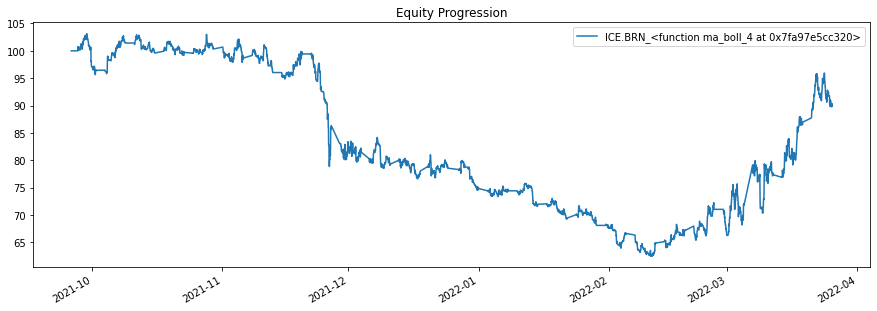

In [19]:
# Set parameters
# start = '2021-05-03'
# end = '2021-12-03'
start=str(date.today() - timedelta(days=180))
end = str(date.today())

short_ma = 12 # период коротких сглаживающих средних EMA
long_ma = 26 # период длинных сглаживающих средних EMA
learn_price = 'Close' # [Open, High, Low, Close]
timeperiod = 14 # timeperiod для RSI, DAX, BBANDS
view = False # вывести графики технического анализа в моделях Price, RSI, DAX, EMA, BBANDS: True=вывести графики, False=не выводить графики

#STL parameters
train_period=5 # На сколько периодов вперед обучаем модель STL
stl_period=7 # это period
toForecast=1 # 1=предсказываем цены, 0=тренируем модель, типа смотрим на качество бэктестов

#Set ARIMA, SARIMAX parameters
order_arima = (2, 2, 2) # Best ARIMA parameters
order_sarimax =(0, 1, 2) # Best SARIMAX parameters
seasonal_order = (0, 1, 0, 7) # Best SARIMAX parameters
# Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:-35.64  for BTC-USD
# Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 7) - AIC:-33.2   for BTC-USD

#Задаём параметр "period". Выбор из:
# ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
# period = [2, 3, 4, 5, 6, 7, 8]

#Задаем параметр "n", где "n"-это номер из списка "ticker", т.е. выбираем тикеры(активы)
# 'US1.AAPL':aaple, 'US1.MSFT':microsoft, 'US1.AMZN':amazon, 'US1.FB':facebook, 'US1.GOOG':google, 'BTSX.BTCUSD':bitcoin, 'BTSX.ETHUSD':ethereum, 
# 'ICE.BRN':Brent, 'NYMEX.CL':WTI, 'NYMEX.NG':Natural GAS, 'comex.GC':gold, 'US2.BIDU':Baidu Corp

#Выбираем источник, откуда будут загружены данные по ценам на активы. True=будет загружено из Yahoo, False=будет загружено из Финам.ru
yahooSource = False # [True=Yahoo, False=Finam]
period = 7 # ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
n = 7 # номер тикера в списке тикеров

if yahooSource==True:
    ticker = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOG', 'BTC-USD', 'ETH-USD', 'BZ=F', 'CL=F', 'NG=F','GC=F', 'BIDU']
    price_data = pdr.data.DataReader(ticker[n], 'yahoo', start, end)
else:
    ticker = ['US1.AAPL', 'US1.MSFT', 'US1.AMZN', 'US1.FB', 'US1.GOOG', 'BTSX.BTCUSD', 'BTSX.ETHUSD', 'ICE.BRN', 'NYMEX.CL', 'NYMEX.NG', 'comex.GC', 'US2.BIDU']
    price_data = finam_export(ticker[n], period, start, end)

data_load = price_data
   
#Выбираем функцию, с помощью которых будут создаваться сигналы на покупку/продажу актива
f_list = [ma_cross, ma_boll_1, ma_boll_2, ma_boll_3, ma_boll_4, ma_boll_5, long_only_ew]
k = 4
function = f_list[k]

# Запускаем функцию, создащие сигналы на покупку/продажу актива
# (ticker, data_load, short_ma=12, long_ma=26, learn_price='Close', timeperiod=14, view=True, name='ma_boll_5'
t = function(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_'+ str(function))
t.data.columns = [ticker[n]]

#Тестируем стратегию и выводим результаты тестирования
res = bt.run(t)
res.plot()
res.display()

# Выводи сигналы, выработанные функцией "сигнальной"
t_view = bt.merge(t.data, t.security_weights)
print(t_view.tail(10))

ticker=ICE.BRN; period=7; start=2021-09-27; end=2022-03-26
Стучимся на Финам по ссылке: https://export.finam.ru/ICE.BRN_2021-09-27_2022-03-26.csv?market=5&em=19473&code=ICE.BRN&apply=0&df=27&mf=8&yf=2021&from=2021-09-27&dt=26&mt=2&yt=2022&to=2022-03-26&p=7&f=ICE.BRN_2021-09-27_2022-03-26_7&e=.csv&cn=ICE.BRN&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
Готово. Проверьте файл stock_price_finam.csv в папке где лежит скрипт
Stat                 ICE.BRN_benchmark    ICE.BRN_macross    ICE.BRN_boll_1    ICE.BRN_boll_4    ICE.BRN_boll_5
-------------------  -------------------  -----------------  ----------------  ----------------  ----------------
Start                2021-09-26           2021-09-26         2021-09-26        2021-09-26        2021-09-26
End                  2022-03-26           2022-03-26         2022-03-26        2022-03-26        2022-03-26
Risk-free rate       0.00%                0.00%              0.00%             0.00%             0.00%

Total Ret

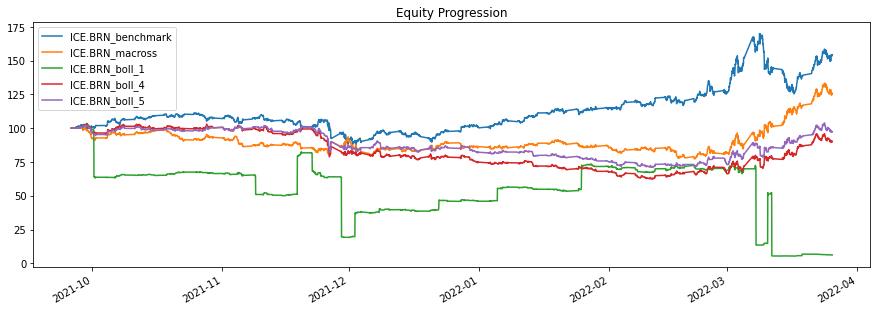

In [20]:
# Set parameters
# start = '2021-05-03'
# end = '2021-12-03'
start=str(date.today() - timedelta(days=180))
end = str(date.today())

short_ma = 12 # период коротких сглаживающих средних EMA
long_ma = 26 # период длинных сглаживающих средних EMA
learn_price = 'Close' # [Open, High, Low, Close]
timeperiod = 14 # timeperiod для RSI, DAX, BBANDS
view = False # вывести графики технического анализа в моделях Price, RSI, DAX, EMA, BBANDS: True=вывести графики, False=не выводить графики

#STL parameters
train_period=5 # На сколько периодов вперед обучаем модель STL
stl_period=7 # это period
toForecast=1 # 1=предсказываем цены, 0=тренируем модель, типа смотрим на качество бэктестов

#Set ARIMA, SARIMAX parameters
order_arima = (2, 2, 2) # Best ARIMA parameters
order_sarimax =(0, 1, 2) # Best SARIMAX parameters
seasonal_order = (0, 1, 0, 7) # Best SARIMAX parameters
# Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:-35.64  for BTC-USD
# Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 7) - AIC:-33.2   for BTC-USD

#Задаём параметр "period". Выбор из:
# ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
# period = [2, 3, 4, 5, 6, 7, 8]

#Задаем параметр "n", где "n"-это номер из списка "ticker", т.е. выбираем тикеры(активы)
# 'US1.AAPL':aaple, 'US1.MSFT':microsoft, 'US1.AMZN':amazon, 'US1.FB':facebook, 'US1.GOOG':google, 'BTSX.BTCUSD':bitcoin, 'BTSX.ETHUSD':ethereum, 
# 'ICE.BRN':Brent, 'NYMEX.CL':WTI, 'NYMEX.NG':Natural GAS, 'comex.GC':gold, 'US2.BIDU':Baidu Corp

#Выбираем источник, откуда будут загружены данные по ценам на активы. True=будет загружено из Yahoo, False=будет загружено из Финам.ru
yahooSource = False # [True=Yahoo, False=Finam]
period = 7 # ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
n = 7 # номер тикера в списке тикеров

if yahooSource==True:
    ticker = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOG', 'BTC-USD', 'ETH-USD', 'BZ=F', 'CL=F', 'NG=F','GC=F', 'BIDU']
    price_data = pdr.data.DataReader(ticker[n], 'yahoo', start, end)
else:
    ticker = ['US1.AAPL', 'US1.MSFT', 'US1.AMZN', 'US1.FB', 'US1.GOOG', 'BTSX.BTCUSD', 'BTSX.ETHUSD', 'ICE.BRN', 'NYMEX.CL', 'NYMEX.NG', 'comex.GC', 'US2.BIDU']
    price_data = finam_export(ticker[n], period, start, end)

data_load = price_data


tbench = long_only_ew(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_benchmark')
tbench.data.columns = [ticker[n]]
tma = ma_cross(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_macross')
tma.data.columns = [ticker[n]]
t1 = ma_boll_1(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_boll_1')
t1.data.columns = [ticker[n]]
t2 = ma_boll_2(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_boll_2')
t2.data.columns = [ticker[n]]
t3 = ma_boll_3(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_boll_3')
t3.data.columns = [ticker[n]]
t4 = ma_boll_4(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_boll_4')
t4.data.columns = [ticker[n]]
t5 = ma_boll_5(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_boll_5')
t5.data.columns = [ticker[n]]

# run all the backtests!
# res2 = bt.run(tbench, tma, t1, t2, t3, t4, t5)
# res2.plot()
# res2.display()

# t_view = bt.merge(tbench.data, tbench.security_weights, tma.security_weights, t1.security_weights, t2.security_weights, t3.security_weights, t4.security_weights, t5.security_weights)
# t_view.columns = ['Price', 'tbench', 'tma', 't1', 't2', 't3', 't4', 't5']
# print(t_view.tail(10))

# run several backtests!
res2 = bt.run(tbench, tma, t1, t4, t5)
res2.plot()
res2.display()

t_view = bt.merge(tbench.data, tma.security_weights, t1.security_weights, t4.security_weights, t5.security_weights)
t_view.columns = ['Price', 'tma', 't1', 't4', 't5']
print(t_view.tail(10))

In [21]:
# print(t_view.tail(50))

In [22]:
# Set parameters
# start = '2021-05-03'
# end = '2021-12-03'
start=str(date.today() - timedelta(days=180))
end = str(date.today())

short_ma = 12 # период коротких сглаживающих средних EMA
long_ma = 26 # период длинных сглаживающих средних EMA
learn_price = 'Close' # [Open, High, Low, Close]
timeperiod = 14 # timeperiod для RSI, DAX, BBANDS
view = False # вывести графики технического анализа в моделях Price, RSI, DAX, EMA, BBANDS: True=вывести графики, False=не выводить графики

#STL parameters
train_period=5 # На сколько периодов вперед обучаем модель STL
stl_period=7 # это period
toForecast=1 # 1=предсказываем цены, 0=тренируем модель, типа смотрим на качество бэктестов

#Set ARIMA, SARIMAX parameters
order_arima = (2, 2, 2) # Best ARIMA parameters
order_sarimax =(0, 1, 2) # Best SARIMAX parameters
seasonal_order = (0, 1, 0, 7) # Best SARIMAX parameters
# Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:-35.64  for BTC-USD
# Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 7) - AIC:-33.2   for BTC-USD

#Задаём параметр "period". Выбор из:
# ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
# period = [2, 3, 4, 5, 6, 7, 8]

#Задаем параметр "n", где "n"-это номер из списка "ticker", т.е. выбираем тикеры(активы)
# 'US1.AAPL':aaple, 'US1.MSFT':microsoft, 'US1.AMZN':amazon, 'US1.FB':facebook, 'US1.GOOG':google, 'BTSX.BTCUSD':bitcoin, 'BTSX.ETHUSD':ethereum, 
# 'ICE.BRN':Brent, 'NYMEX.CL':WTI, 'NYMEX.NG':Natural GAS, 'comex.GC':gold, 'US2.BIDU':Baidu Corp

#Выбираем источник, откуда будут загружены данные по ценам на активы. True=будет загружено из Yahoo, False=будет загружено из Финам.ru
yahooSource = False # [True=Yahoo, False=Finam]
period = 7 # ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
n = 7 # номер тикера в списке тикеров

if yahooSource==True:
    ticker = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOG', 'BTC-USD', 'ETH-USD', 'BZ=F', 'CL=F', 'NG=F','GC=F', 'BIDU']
    price_data = pdr.data.DataReader(ticker[n], 'yahoo', start, end)
else:
    ticker = ['US1.AAPL', 'US1.MSFT', 'US1.AMZN', 'US1.FB', 'US1.GOOG', 'BTSX.BTCUSD', 'BTSX.ETHUSD', 'ICE.BRN', 'NYMEX.CL', 'NYMEX.NG', 'comex.GC', 'US2.BIDU']
    price_data = finam_export(ticker[n], period, start, end)

data_load = price_data
data = data_load[learn_price]
test_stationarity(data)

ticker=ICE.BRN; period=7; start=2021-09-27; end=2022-03-26
Стучимся на Финам по ссылке: https://export.finam.ru/ICE.BRN_2021-09-27_2022-03-26.csv?market=5&em=19473&code=ICE.BRN&apply=0&df=27&mf=8&yf=2021&from=2021-09-27&dt=26&mt=2&yt=2022&to=2022-03-26&p=7&f=ICE.BRN_2021-09-27_2022-03-26_7&e=.csv&cn=ICE.BRN&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
Готово. Проверьте файл stock_price_finam.csv в папке где лежит скрипт
Results of Dickey-Fuller Test:
Test Statistic                   -0.079
p-value                           0.951
#Lags Used                       28.000
Number of Observations Used    2925.000
Critical Value (1%)              -3.433
Critical Value (5%)              -2.863
Critical Value (10%)             -2.567
dtype: float64


ticker=ICE.BRN; period=7; start=2021-09-27; end=2022-03-26
Стучимся на Финам по ссылке: https://export.finam.ru/ICE.BRN_2021-09-27_2022-03-26.csv?market=5&em=19473&code=ICE.BRN&apply=0&df=27&mf=8&yf=2021&from=2021-09-27&dt=26&mt=2&yt=2022&to=2022-03-26&p=7&f=ICE.BRN_2021-09-27_2022-03-26_7&e=.csv&cn=ICE.BRN&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
Готово. Проверьте файл stock_price_finam.csv в папке где лежит скрипт
order_arima= (2, 2, 2)


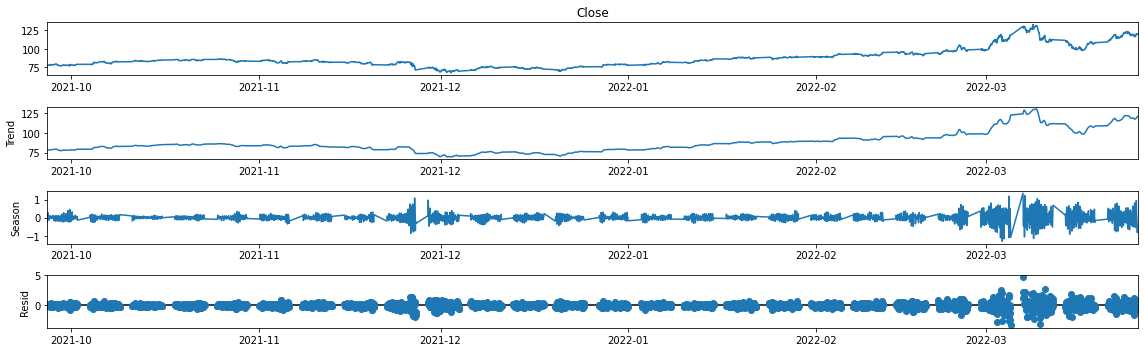

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `st

                        predict  history       trend
2022-03-25 21:00:00  119.280000   119.28  119.220292
2022-03-25 22:00:00  119.890000   119.89  119.591630
2022-03-25 23:00:00  119.480000   119.48  119.961563
2022-03-26 00:00:00  119.380000   119.38  120.328540
2022-03-26 01:00:00  119.990000   119.99  120.691837
2954                 120.867159      NaN         NaN
2955                 121.577243      NaN         NaN
2956                 120.974603      NaN         NaN
2957                 120.677356      NaN         NaN
2958                 120.325828      NaN         NaN


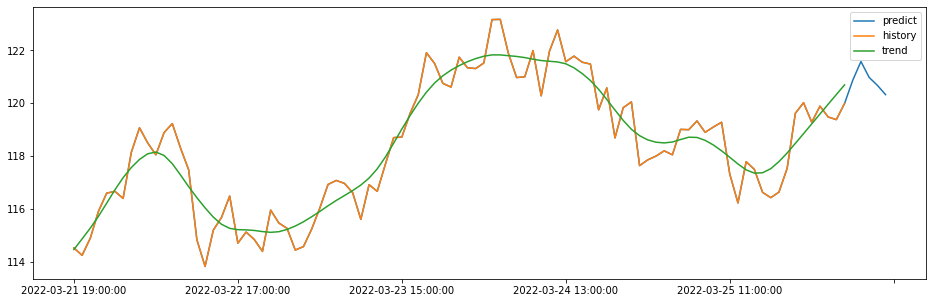

In [23]:
# Set parameters
# start = '2021-05-03'
# end = '2021-12-03'
start=str(date.today() - timedelta(days=180))
end = str(date.today())

short_ma = 12 # период коротких сглаживающих средних EMA
long_ma = 26 # период длинных сглаживающих средних EMA
learn_price = 'Close' # [Open, High, Low, Close]
timeperiod = 14 # timeperiod для RSI, DAX, BBANDS
view = False # вывести графики технического анализа в моделях Price, RSI, DAX, EMA, BBANDS: True=вывести графики, False=не выводить графики

#STL parameters
train_period=5 # На сколько периодов вперед обучаем модель STL
stl_period=7 # это period
toForecast=True # 1=предсказываем цены, 0=тренируем модель, типа смотрим на качество бэктестов

#Set ARIMA, SARIMAX parameters
order_arima = (2, 2, 2) # Best ARIMA parameters
order_sarimax =(0, 1, 2) # Best SARIMAX parameters
seasonal_order = (0, 1, 0, 7) # Best SARIMAX parameters
# Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:-35.64  for BTC-USD
# Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 7) - AIC:-33.2   for BTC-USD

#Задаём параметр "period". Выбор из:
# ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
# period = [2, 3, 4, 5, 6, 7, 8]

#Задаем параметр "n", где "n"-это номер из списка "ticker", т.е. выбираем тикеры(активы)
# 'US1.AAPL':aaple, 'US1.MSFT':microsoft, 'US1.AMZN':amazon, 'US1.FB':facebook, 'US1.GOOG':google, 'BTSX.BTCUSD':bitcoin, 'BTSX.ETHUSD':ethereum, 
# 'ICE.BRN':Brent, 'NYMEX.CL':WTI, 'NYMEX.NG':Natural GAS, 'comex.GC':gold, 'US2.BIDU':Baidu Corp

#Выбираем источник, откуда будут загружены данные по ценам на активы. True=будет загружено из Yahoo, False=будет загружено из Финам.ru
yahooSource = False # [True=Yahoo, False=Finam]
period = 7 # ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
n = 7 # номер тикера в списке тикеров

if yahooSource==True:
    ticker = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOG', 'BTC-USD', 'ETH-USD', 'BZ=F', 'CL=F', 'NG=F','GC=F', 'BIDU']
    price_data = pdr.data.DataReader(ticker[n], 'yahoo', start, end)
else:
    ticker = ['US1.AAPL', 'US1.MSFT', 'US1.AMZN', 'US1.FB', 'US1.GOOG', 'BTSX.BTCUSD', 'BTSX.ETHUSD', 'ICE.BRN', 'NYMEX.CL', 'NYMEX.NG', 'comex.GC', 'US2.BIDU']
    price_data = finam_export(ticker[n], period, start, end)

data_load = price_data#[:-1]
data = data_load[learn_price]
data_train = data.iloc[:-train_period]
data_test = data.iloc[train_period:]

#Давайте попробуем найти самые лучшие параметры для модели ARIMA.
need_find_param = False
if need_find_param==True:
    # Let's find the best parameters for ARIMA model
    # set parameter range
    p,d,q = range(0,3),range(0,3),range(0,3)
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    all_param = pdq
    exo = data.copy()
    exo_train = data_train.copy()
    all_res = arima(data_train,exo_train,all_param)
    all_res.sort(key=lambda x: abs(x[1]), reverse=False)
    print(all_res[:5])
    order_arima = all_res[0][2]

print(f"order_arima= {order_arima}")

stl_y = stl_arima(ticker=ticker[n], data_load=data_load, learn_price=learn_price, train_period=train_period, stl_period=stl_period, order_arima=order_arima, toForecast=toForecast)

In [24]:
order_arima

(2, 2, 2)

ticker=ICE.BRN; period=8; start=2021-09-27; end=2022-03-26
Стучимся на Финам по ссылке: https://export.finam.ru/ICE.BRN_2021-09-27_2022-03-26.csv?market=5&em=19473&code=ICE.BRN&apply=0&df=27&mf=8&yf=2021&from=2021-09-27&dt=26&mt=2&yt=2022&to=2022-03-26&p=8&f=ICE.BRN_2021-09-27_2022-03-26_8&e=.csv&cn=ICE.BRN&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
Готово. Проверьте файл stock_price_finam.csv в папке где лежит скрипт
order_sarimax=(0, 1, 2), seasonal_order=(0, 1, 0, 7)


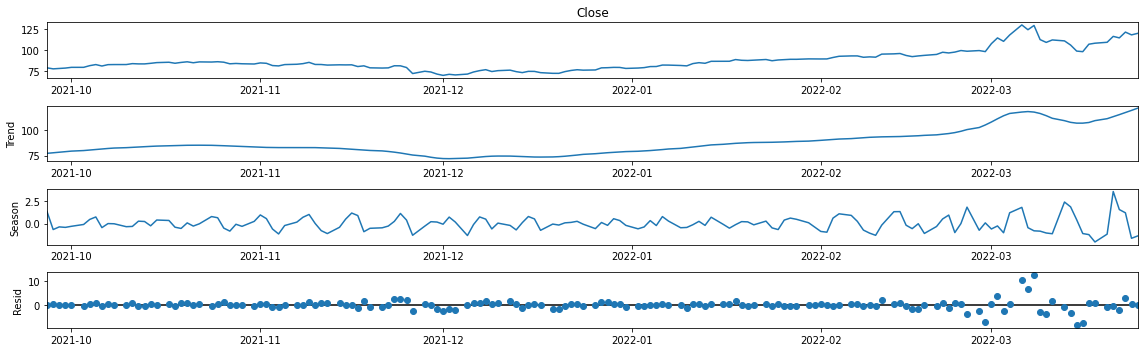

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


                        predict  history       trend
2022-03-21 00:00:00  116.400000   116.40  113.182327
2022-03-22 00:00:00  114.580000   114.58  115.191488
2022-03-23 00:00:00  121.520000   121.52  117.248046
2022-03-24 00:00:00  118.200000   118.20  119.347548
2022-03-25 00:00:00  119.990000   119.99  121.479544
155                  121.359418      NaN         NaN
156                  122.770256      NaN         NaN
157                  129.860256      NaN         NaN
158                  128.040256      NaN         NaN
159                  134.980256      NaN         NaN


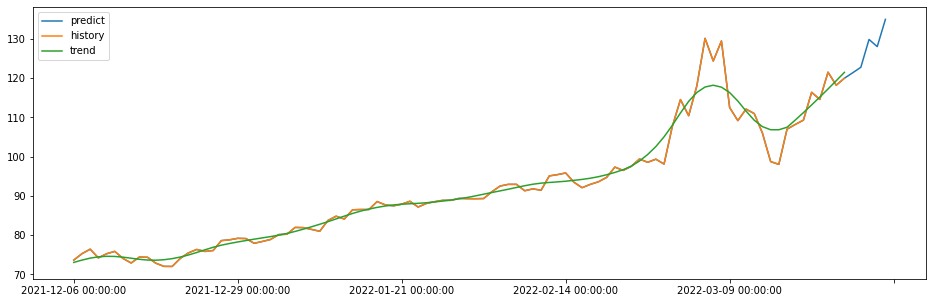

In [25]:
# Set parameters
# start = '2021-05-03'
# end = '2021-12-03'
start=str(date.today() - timedelta(days=180))
end = str(date.today())

short_ma = 12 # период коротких сглаживающих средних EMA
long_ma = 26 # период длинных сглаживающих средних EMA
learn_price = 'Close' # [Open, High, Low, Close]
timeperiod = 14 # timeperiod для RSI, DAX, BBANDS
view = False # вывести графики технического анализа в моделях Price, RSI, DAX, EMA, BBANDS: True=вывести графики, False=не выводить графики

#STL parameters
train_period=5 # На сколько периодов вперед обучаем модель STL
stl_period=7 # это period
toForecast=1 # 1=предсказываем цены, 0=тренируем модель, типа смотрим на качество бэктестов

#Set ARIMA, SARIMAX parameters
order_arima = (2, 2, 2) # Best ARIMA parameters
order_sarimax =(0, 1, 2) # Best SARIMAX parameters
seasonal_order = (0, 1, 0, 7) # Best SARIMAX parameters
# Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:-35.64  for BTC-USD
# Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 7) - AIC:-33.2   for BTC-USD

#Задаём параметр "period". Выбор из:
# ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
# period = [2, 3, 4, 5, 6, 7, 8]

#Задаем параметр "n", где "n"-это номер из списка "ticker", т.е. выбираем тикеры(активы)
# 'US1.AAPL':aaple, 'US1.MSFT':microsoft, 'US1.AMZN':amazon, 'US1.FB':facebook, 'US1.GOOG':google, 'BTSX.BTCUSD':bitcoin, 'BTSX.ETHUSD':ethereum, 
# 'ICE.BRN':Brent, 'NYMEX.CL':WTI, 'NYMEX.NG':Natural GAS, 'comex.GC':gold, 'US2.BIDU':Baidu Corp

#Выбираем источник, откуда будут загружены данные по ценам на активы. True=будет загружено из Yahoo, False=будет загружено из Финам.ru
yahooSource = False # [True=Yahoo, False=Finam]
period = 8 # ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
n = 7 # номер тикера в списке тикеров

if yahooSource==True:
    ticker = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOG', 'BTC-USD', 'ETH-USD', 'BZ=F', 'CL=F', 'NG=F','GC=F', 'BIDU']
    price_data = pdr.data.DataReader(ticker[n], 'yahoo', start, end)
else:
    ticker = ['US1.AAPL', 'US1.MSFT', 'US1.AMZN', 'US1.FB', 'US1.GOOG', 'BTSX.BTCUSD', 'BTSX.ETHUSD', 'ICE.BRN', 'NYMEX.CL', 'NYMEX.NG', 'comex.GC', 'US2.BIDU']
    price_data = finam_export(ticker[n], period, start, end)

data_load = price_data#[:-1]
data = data_load[learn_price]
data_train = data.iloc[:-train_period]
data_test = data.iloc[train_period:]

#Давайте попробуем найти самые лучшие параметры для модели ARIMA.
need_find_param = False
if need_find_param==True:
    # Let's find the best parameters for SARIMAX model
    # set parameter range
    p,d,q = range(0,3),[1],range(0,3)
    P,D,Q,s = range(0,3),[1],range(0,3),[7]
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, s))
    all_param = list(itertools.product(pdq,seasonal_pdq))
    exo = data.copy()
    exo_train = data_train.copy()
    all_res = sarimax(data_train,exo_train,all_param)
    all_res.sort(key=lambda x: x[1], reverse=True)
    print(all_res[:5])
    order_sarimax = all_res[0][2][0]
    seasonal_order = all_res[0][2][0]

print(f"order_sarimax={order_sarimax}, seasonal_order={seasonal_order}")

# ticker, data_load, learn_price="Close", train_period=5, stl_period=5, toForecast=True, order_sarimax=(0, 1, 2), seasonal_order=(0, 1, 0, 7)
stl_y = stl_sarimax(ticker=ticker[n], data_load=data_load, learn_price=learn_price, train_period=train_period, stl_period=stl_period, toForecast=toForecast, order_sarimax=order_sarimax, seasonal_order=seasonal_order)

ticker=ICE.BRN; period=7; start=2021-09-27; end=2022-03-26
Стучимся на Финам по ссылке: https://export.finam.ru/ICE.BRN_2021-09-27_2022-03-26.csv?market=5&em=19473&code=ICE.BRN&apply=0&df=27&mf=8&yf=2021&from=2021-09-27&dt=26&mt=2&yt=2022&to=2022-03-26&p=7&f=ICE.BRN_2021-09-27_2022-03-26_7&e=.csv&cn=ICE.BRN&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
Готово. Проверьте файл stock_price_finam.csv в папке где лежит скрипт
Stat                 ICE.BRN_benchmark    ICE.BRN_macross    ICE.BRN_boll_1    ICE.BRN_boll_4    ICE.BRN_boll_5
-------------------  -------------------  -----------------  ----------------  ----------------  ----------------
Start                2021-09-26           2021-09-26         2021-09-26        2021-09-26        2021-09-26
End                  2022-03-26           2022-03-26         2022-03-26        2022-03-26        2022-03-26
Risk-free rate       0.00%                0.00%              0.00%             0.00%             0.00%

Total Ret

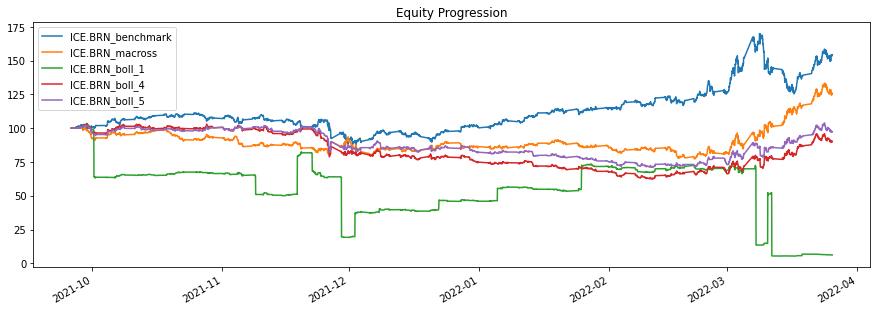

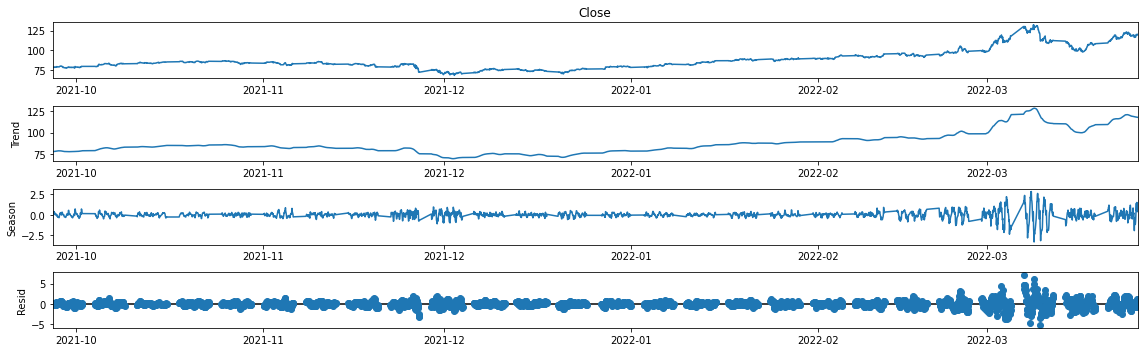

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


                        predict  history       trend
2022-03-25 21:00:00  119.280000   119.28  118.045298
2022-03-25 22:00:00  119.890000   119.89  117.997709
2022-03-25 23:00:00  119.480000   119.48  117.951864
2022-03-26 00:00:00  119.380000   119.38  117.907745
2022-03-26 01:00:00  119.990000   119.99  117.865322
2954                 120.022609      NaN         NaN
2955                 119.858636      NaN         NaN
2956                 119.866203      NaN         NaN
2957                 120.026692      NaN         NaN
2958                 120.203589      NaN         NaN


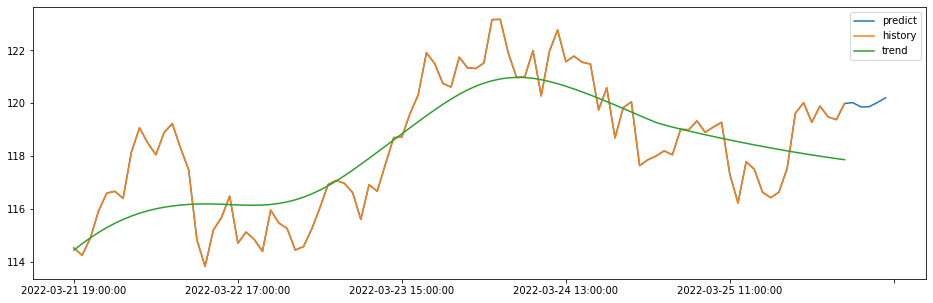

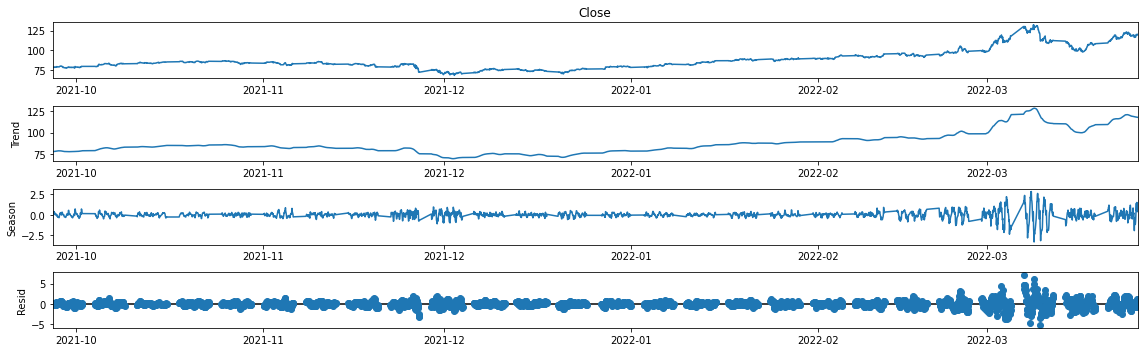

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


                        predict  history       trend
2022-03-25 21:00:00  119.280000   119.28  118.045298
2022-03-25 22:00:00  119.890000   119.89  117.997709
2022-03-25 23:00:00  119.480000   119.48  117.951864
2022-03-26 00:00:00  119.380000   119.38  117.907745
2022-03-26 01:00:00  119.990000   119.99  117.865322
2954                 120.022609      NaN         NaN
2955                 119.858636      NaN         NaN
2956                 119.866203      NaN         NaN
2957                 120.026692      NaN         NaN
2958                 120.203589      NaN         NaN
Stat                 ICE.BRN_<function ma_boll_4 at 0x7fa97e5cc320>
-------------------  ------------------------------------------------
Start                2021-09-26
End                  2022-03-26
Risk-free rate       0.00%

Total Return         -9.69%
Daily Sharpe         -0.21
Daily Sortino        -0.37
CAGR                 -18.60%
Max Drawdown         -39.01%
Calmar Ratio         -0.48

MTD                

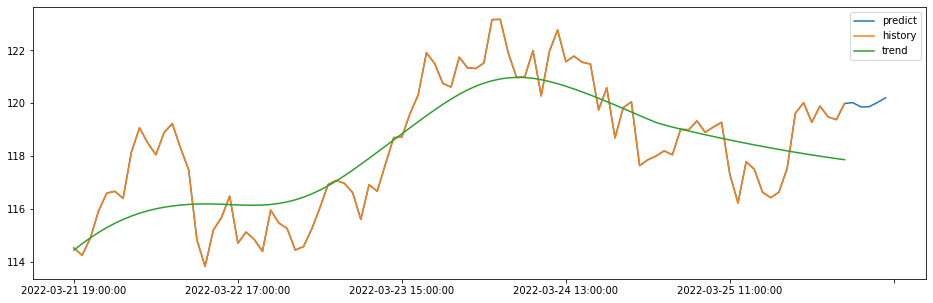

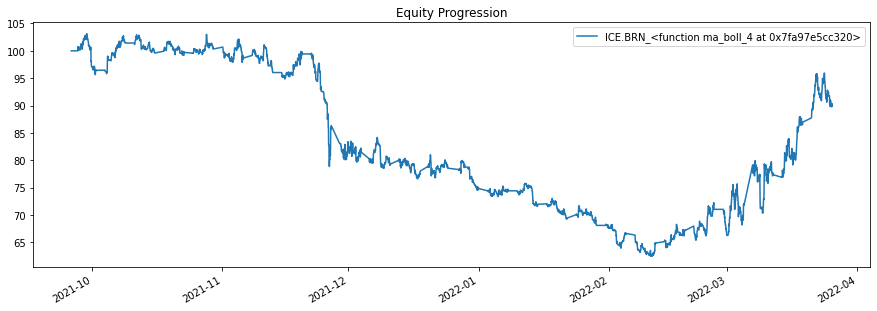

In [26]:
# Set parameters
# start = '2021-05-03'
# end = '2021-12-03'
start=str(date.today() - timedelta(days=180))
end = str(date.today())

short_ma = 12 # период коротких сглаживающих средних EMA
long_ma = 26 # период длинных сглаживающих средних EMA
learn_price = 'Close' # [Open, High, Low, Close]
timeperiod = 14 # timeperiod для RSI, DAX, BBANDS
view = False # вывести графики технического анализа в моделях Price, RSI, DAX, EMA, BBANDS: True=вывести графики, False=не выводить графики

#STL parameters
train_period=1 # На сколько периодов вперед обучаем модель STL
stl_period=24 # это period
toForecast=1 # 1=предсказываем цены, 0=тренируем модель, типа смотрим на качество бэктестов

#Set ARIMA, SARIMAX parameters
order_arima = (2, 2, 2) # Best ARIMA parameters
order_sarimax =(0, 1, 2) # Best SARIMAX parameters
seasonal_order = (0, 1, 0, 7) # Best SARIMAX parameters
# Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:-35.64  for BTC-USD
# Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 7) - AIC:-33.2   for BTC-USD

#Задаём параметр "period". Выбор из:
# ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
# period = [2, 3, 4, 5, 6, 7, 8]

#Задаем параметр "n", где "n"-это номер из списка "ticker", т.е. выбираем тикеры(активы)
# 'US1.AAPL':aaple, 'US1.MSFT':microsoft, 'US1.AMZN':amazon, 'US1.FB':facebook, 'US1.GOOG':google, 'BTSX.BTCUSD':bitcoin, 'BTSX.ETHUSD':ethereum, 
# 'ICE.BRN':Brent, 'NYMEX.CL':WTI, 'NYMEX.NG':Natural GAS, 'comex.GC':gold, 'US2.BIDU':Baidu Corp

#Выбираем источник, откуда будут загружены данные по ценам на активы. True=будет загружено из Yahoo, False=будет загружено из Финам.ru
yahooSource = False # [True=Yahoo, False=Finam]
period = 7 # ['min=1': 2, '5min=5': 3, '10min=10': 4, '15min=15': 5, '30min=30': 6, 'Hour=60': 7, 'daily=D': 8, 'week=W': 9, 'month=M': 10]
n = 7 # номер тикера в списке тикеров

if yahooSource==True:
    ticker = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOG', 'BTC-USD', 'ETH-USD', 'BZ=F', 'CL=F', 'NG=F','GC=F', 'BIDU']
    price_data = pdr.data.DataReader(ticker[n], 'yahoo', start, end)
else:
    ticker = ['US1.AAPL', 'US1.MSFT', 'US1.AMZN', 'US1.FB', 'US1.GOOG', 'BTSX.BTCUSD', 'BTSX.ETHUSD', 'ICE.BRN', 'NYMEX.CL', 'NYMEX.NG', 'comex.GC', 'US2.BIDU']
    price_data = finam_export(ticker[n], period, start, end)

data_load = price_data#[:-1]
data = data_load[learn_price]
data_train = data.iloc[:-train_period]
data_test = data.iloc[train_period:]

tbench = long_only_ew(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_benchmark')
tbench.data.columns = [ticker[n]]
tma = ma_cross(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_macross')
tma.data.columns = [ticker[n]]
t1 = ma_boll_1(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_boll_1')
t1.data.columns = [ticker[n]]
# t2 = ma_boll_2(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_boll_2')
# t2.data.columns = [ticker[n]]
# t3 = ma_boll_3(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_boll_3')
# t3.data.columns = [ticker[n]]
t4 = ma_boll_4(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_boll_4')
t4.data.columns = [ticker[n]]
t5 = ma_boll_5(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_boll_5')
t5.data.columns = [ticker[n]]

# run several backtests!
res2 = bt.run(tbench, tma, t1, t4, t5)
res2.plot()
res2.display()

t_view = bt.merge(tbench.data, tma.security_weights, t1.security_weights, t4.security_weights, t5.security_weights)
t_view.columns = ['Price', 'tma', 't1', 't4', 't5']
print(t_view.tail(10))

stl_y = stl_sarimax(ticker=ticker[n], data_load=data_load, learn_price=learn_price, train_period=train_period, stl_period=stl_period, toForecast=toForecast, order_sarimax=order_sarimax, seasonal_order=seasonal_order)
stl_y = stl_sarimax(ticker=ticker[n], data_load=data_load, learn_price=learn_price, train_period=train_period, stl_period=stl_period, toForecast=toForecast, order_sarimax=order_sarimax, seasonal_order=seasonal_order)

#Выбираем функцию, с помощью которых будут создаваться сигналы на покупку/продажу актива
f_list = [ma_cross, ma_boll_1, ma_boll_2, ma_boll_3, ma_boll_4, ma_boll_5, long_only_ew]
k = 4
function = f_list[k]

# Запускаем функцию, создащие сигналы на покупку/продажу актива
t = function(ticker[n], data_load=data_load, short_ma=short_ma, long_ma=long_ma, learn_price=learn_price, timeperiod=timeperiod, view=view, name=ticker[n]+'_'+ str(function))
t.data.columns = [ticker[n]]

#Тестируем стратегию и выводим результаты тестирования
res = bt.run(t)
res.plot()
res.display()

# Выводи сигналы, выработанные функцией "сигнальной"
t_view = bt.merge(t.data, t.security_weights)
print(t_view.tail(10))

In [27]:
# #Let's find the best ARIMA parameters
# data_train = data.iloc[:-train_period]
# data_test = data.iloc[train_period:]
# # set parameter range
# p,d,q = range(0,3),range(0,3),range(0,3)
# # list of all parameter combos
# pdq = list(itertools.product(p, d, q))
# all_param = pdq
# exo = data.copy()
# exo_train = data_train.copy()
# all_res = arima(data_train,exo_train,all_param)
# all_res.sort(key=lambda x: abs(x[1]), reverse=False)
# print(all_res[:5])
# order_arima = all_res[0][2]

In [28]:
# # Let's find the best parameters for SARIMAX model
# # set parameter range
# p,d,q = range(0,3),[1],range(0,3)
# P,D,Q,s = range(0,3),[1],range(0,3),[7]
# # list of all parameter combos
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = list(itertools.product(P, D, Q, s))
# all_param = list(itertools.product(pdq,seasonal_pdq))
# exo = data.copy()
# exo_train = data_train.copy()
# all_res = sarimax(data_train,exo_train,all_param)
# all_res.sort(key=lambda x: x[1], reverse=True)
# print(all_res[:5])
# order_sarimax = all_res[0][2][0]
# seasonal_order = all_res[0][2][0]
